In [1]:
import sys
import inspect
from importlib import reload
from tqdm import tqdm

import numpy as np
import numexpr as ne
import matplotlib.pyplot as plt
from matplotlib import rcParams
from scipy.constants import pi, c, epsilon_0, mu_0

rcParams['figure.figsize'] = (8,6)
rcParams['font.size'] = 20

import quvac
from quvac.paraxial_gaussian import ParaxialGaussianAnalytic
from quvac.field import ExternalField
from quvac.vacuum_emission import VacuumEmission
from quvac.analytic_scalings import get_two_paraxial_scaling
from quvac.grid_utils import get_xyz_size, get_t_size
reload(quvac.analytic_scalings)

<module 'quvac.analytic_scalings' from '/home/maximus/Research/github/quantum-vacuum/src/quvac/analytic_scalings.py'>

## Test: two paraxial gaussians for different collision angles

In [11]:
tau = 15e-15
W = 25
lam = 0.8e-6
w0 = 2*lam
theta = 90
beta = 90
thetas = np.linspace(0,180,19)

field_1 = {
    "field_type": "paraxial_gaussian_analytic",
    "focus_x": (0.,0.,0.),
    "focus_t": 0.,
    "theta": 0,
    "phi": 0,
    "beta": 0,
    "lam": lam,
    "w0": w0,
    "tau": tau,
    "W": W,
    "phase0": 0,
}

field_2 = {
    "field_type": "paraxial_gaussian_analytic",
    "focus_x": (0.,0.,0.),
    "focus_t": 0.,
    "theta": theta,
    "phi": 0,
    "beta": beta,
    "lam": lam,
    "w0": w0,
    "tau": tau,
    "W": W,
    "phase0": 0,
}

fields_params = [field_1, field_2]

x0, y0, z0 = 15*w0, 15*w0, 7*c*tau
L = np.array([x0, y0, z0])
Nxyz = get_xyz_size(fields_params, L/2)
print(Nxyz)
Nx, Ny, Nz = Nxyz
x = np.linspace(-x0/2,x0/2,Nx).reshape((-1,1,1))
y = np.linspace(-y0/2,y0/2,Ny).reshape((1,-1,1))
z = np.linspace(-z0/2,z0/2,Nz).reshape((1,1,-1))
grid = (x, y, z)

t0 = 2*tau
Nt = get_t_size(-t0, t0, lam)
print(Nt)
t_grid = np.linspace(-t0, t0, Nt)

[112, 30, 147]
135


In [4]:
Ntots = np.zeros_like(thetas)
Nths = np.zeros_like(thetas)

In [7]:
for i,theta in enumerate(tqdm(thetas)):
    field_2['theta'] = float(theta)
    fields_params = [field_1, field_2]

    x0, y0, z0 = 4*c*tau, 12*w0, 4*c*tau
    L = np.array([x0, y0, z0])
    Nxyz = get_spatial_steps(fields_params, L/2)
    print(Nxyz)
    Nx, Ny, Nz = Nxyz
    x = np.linspace(-x0/2,x0/2,2*Nx).reshape((-1,1,1))
    y = np.linspace(-y0/2,y0/2,2*Ny).reshape((1,-1,1))
    z = np.linspace(-z0/2,z0/2,2*Nz).reshape((1,1,-1))
    grid = (x, y, z)
    
    field = ExternalField(fields_params, grid)
    vacem = VacuumEmission(field)
    vacem.calculate_vacuum_current(t_grid)
    Ntot = vacem.calculate_total_signal()
    Ntots[i] = Ntot

    N_signal, N_perp = get_two_paraxial_scaling(fields_params)
    Nths[i] = N_signal

  0%|                                                                        | 0/19 [00:00<?, ?it/s]

[ 72  23 128]


/home/maximus/Research/github/quantum-vacuum/src/quvac/analytic_scalings.py:54: RuntimeWarning: invalid value encountered in scalar divide
  theta_term = (1 - np.cos(theta_c))**4 / np.sqrt(cos_term + sin_term)
/home/maximus/Research/github/quantum-vacuum/src/quvac/analytic_scalings.py:55: RuntimeWarning: divide by zero encountered in scalar divide
  theta_term *= 1/np.sqrt((T1/tau1*w01/w1)**2*cos_term + sin_term)
  5%|███▎                                                           | 1/19 [02:13<40:11, 133.97s/it]

nan
nan
[ 93  23 139]


 11%|██████▍                                                      | 2/19 [07:14<1:05:39, 231.74s/it]

1.399062386501732e-05
2.798124773003464e-05
[111  23 145]


 16%|█████████▋                                                   | 3/19 [13:03<1:16:06, 285.41s/it]

0.0008945497037529999
0.0017890994075059998
[126  23 147]


 21%|████████████▊                                                | 4/19 [17:09<1:07:29, 269.97s/it]

0.010175881867334279
0.020351763734668557
[137  23 144]


 26%|████████████████                                             | 5/19 [23:16<1:11:09, 304.95s/it]

0.05709857912778438
0.11419715825556875
[144  23 137]


 32%|███████████████████▎                                         | 6/19 [29:48<1:12:30, 334.62s/it]

0.21764891850017948
0.43529783700035896
[147  23 128]


 37%|██████████████████████▍                                      | 7/19 [34:05<1:01:50, 309.21s/it]

0.65029706593073
1.30059413186146
[145  23 128]


 42%|██████████████████████████▌                                    | 8/19 [39:15<56:41, 309.24s/it]

1.644835333251884
3.289670666503768
[139  23 128]


 47%|█████████████████████████████▊                                 | 9/19 [45:01<53:27, 320.78s/it]

3.690465768423462
7.380931536846924
[128  23 128]


 53%|████████████████████████████████▋                             | 10/19 [48:33<43:06, 287.41s/it]

7.576805292774131
15.153610585548263
[139  23 128]


 58%|███████████████████████████████████▉                          | 11/19 [54:15<40:31, 303.97s/it]

14.55630436399616
29.11260872799232
[145  23 128]


 63%|███████████████████████████████████████▏                      | 12/19 [59:19<35:27, 303.91s/it]

26.625872520302117
53.251745040604234
[147  23 128]


 68%|█████████████████████████████████████████                   | 13/19 [1:03:36<28:59, 289.91s/it]

47.0424901618091
94.0849803236182
[144  23 137]


 74%|████████████████████████████████████████████▏               | 14/19 [1:10:04<26:37, 319.44s/it]

81.28679794729233
162.57359589458466
[137  23 144]


 79%|███████████████████████████████████████████████▎            | 15/19 [1:16:11<22:15, 333.86s/it]

138.77331256296588
277.54662512593177
[126  23 147]


 84%|██████████████████████████████████████████████████▌         | 16/19 [1:20:23<15:27, 309.14s/it]

235.0258178705916
470.0516357411832
[111  23 145]


 89%|█████████████████████████████████████████████████████▋      | 17/19 [1:26:14<10:43, 321.80s/it]

388.78335671019147
777.5667134203829
[ 93  23 139]


 95%|████████████████████████████████████████████████████████▊   | 18/19 [1:31:10<05:13, 313.83s/it]

586.3195079174238
1172.6390158348477
[ 72  23 128]


100%|████████████████████████████████████████████████████████████| 19/19 [1:33:12<00:00, 294.35s/it]

695.3163027298156
1390.6326054596311


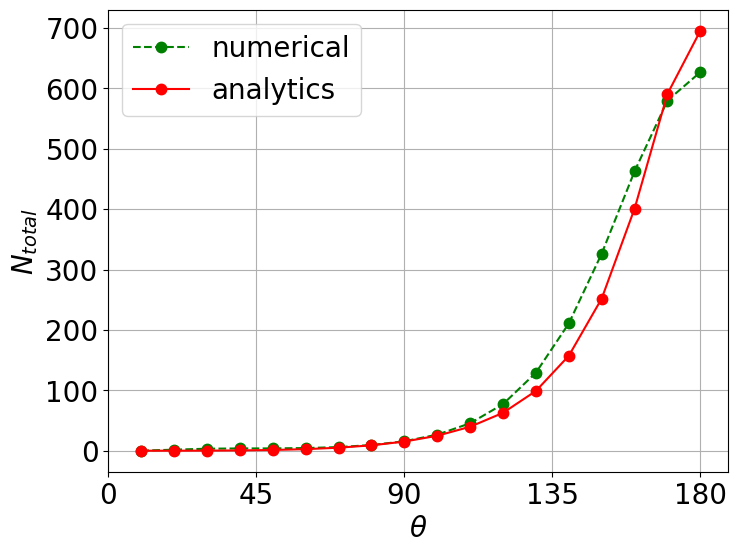

In [16]:
# This is for comparison with Fig.6 from H. Gies, et al "All-optical signatures of 
# strong-field QED in the vacuum emission picture." Physical Review D 97.3 (2018): 036022.

correction = 1 - np.cos(thetas[1:]*np.pi/180)

plt.figure(figsize=(8,6))
# plt.subplot(1,2,1)
plt.plot(thetas[1:], Ntots[1:], '.--', color='green', ms=15, label='numerical')
plt.plot(thetas[1:], Nths[1:]/correction, '.-', color='red', ms=15, label='analytics')
# plt.yscale('log')
plt.grid()
plt.xlabel('$\\theta$')
plt.ylabel('$N_{total}$')
plt.xticks([45*i for i in range(5)])
plt.legend(loc='best')
# plt.yticks([50*i for i in range(7)])

# plt.subplot(1,2,2)
# plt.plot(thetas[1:], np.abs(Ntots-Nths)[1:]/Nths[1:]*100, '.--', color='tab:blue', ms=15, label='relative error')
# # plt.plot(thetas, Nths, '.-', color='red', ms=15, label='analytics')
# plt.grid()
# plt.xlabel('$\\theta$')
# plt.ylabel('Error [%]')
# plt.xticks([45*i for i in range(5)])
# # plt.legend(loc='best')

plt.savefig('../imgs/tests/2_paraxial_Ntot_theta_beta_90_correction.png', bbox_inches='tight')
plt.show()

In [ ]:
plt.figure()
plt.plot(thetas, np.abs(Ntots-Nths)/Nths*100, '.--', color='green', ms=15, label='relative error')
# plt.plot(thetas, Nths, '.-', color='red', ms=15, label='analytics')
plt.grid()
plt.xlabel('$\\theta$')
plt.ylabel('Error [%]')
plt.xticks([45*i for i in range(5)])
plt.legend(loc='best')
plt.savefig('../imgs/tests/2_paraxial_Ntot_theta_beta_90_error.png')
plt.show()

In [12]:
N_signal, N_perp = get_two_paraxial_scaling(fields_params)
print(N_signal)
print(N_perp)

7.304224240096958
5.030165093345488e-33


In [13]:
field = ExternalField(fields_params, grid)
vacem = VacuumEmission(field)
vacem.calculate_vacuum_current(t_grid)
Ntot = vacem.calculate_total_signal()
print(Ntot)

7.369848262274903


In [37]:
field = ExternalField(fields_params, grid)
vacem = VacuumEmission(field)
vacem.calculate_vacuum_current(t_grid)
Ntot = vacem.calculate_total_signal()
print(Ntot)

273.9379486825402


In [34]:
field = ExternalField(fields_params, grid)
vacem = VacuumEmission(field)
vacem.calculate_vacuum_current(t_grid)
Ntot = vacem.calculate_total_signal()
print(Ntot)

391.7127139989134


In [28]:
field = ExternalField(fields_params, grid)
vacem = VacuumEmission(field)
vacem.calculate_vacuum_current(t_grid)
Ntot = vacem.calculate_total_signal()
print(Ntot)

625.9140622380058


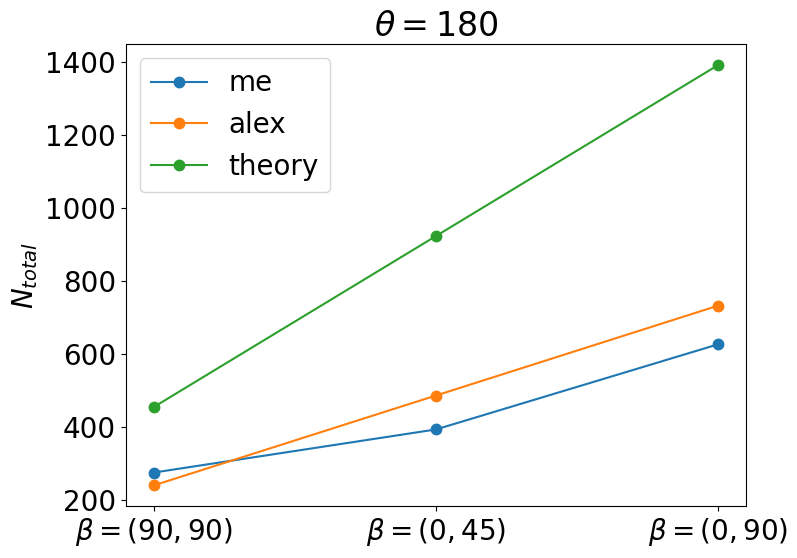

In [57]:
my_data = [274, 392, 625]
alex_data = [239, 485, 731]
theory_data = [454, 922, 1390]

plt.figure()
plt.plot(my_data, '.-', ms=15, label='me')
plt.plot(alex_data, '.-', ms=15, label='alex')
plt.plot(theory_data, '.-', ms=15, label='theory')
plt.xticks([0,1,2], labels=['$\\beta=(90,90)$', '$\\beta=(0,45)$', '$\\beta=(0,90)$'])
plt.ylabel("$N_{total}$")
plt.title('$\\theta = 180$')
plt.legend()
plt.show()

In [11]:
Ntot*2

np.float64(870.3000753625385)

In [12]:
N_signal / Ntot

np.float64(2.119632956207241)

In [31]:
Ntots = np.zeros_like(thetas)

In [32]:
for i,theta in enumerate(tqdm(thetas)):
    field_2['theta'] = float(theta)
    fields_params = [field_1, field_2]
    
    field = ExternalField(fields_params, grid)
    vacem = VacuumEmission(field)
    vacem.calculate_vacuum_current(t_grid)
    Ntot = vacem.calculate_total_signal()
    Ntots[i] = Ntot

100%|███████████████████████████████████████████| 19/19 [01:58<00:00,  6.25s/it]


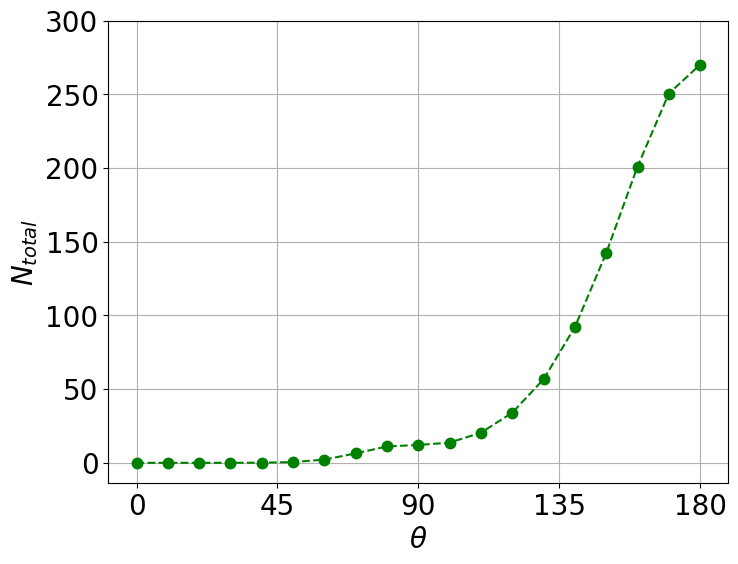

In [33]:
# This is for comparison with Fig.6 from H. Gies, et al "All-optical signatures of 
# strong-field QED in the vacuum emission picture." Physical Review D 97.3 (2018): 036022.

plt.figure()
plt.plot(thetas, Ntots, '.--', color='green', ms=15)
plt.grid()
plt.xlabel('$\\theta$')
plt.ylabel('$N_{total}$')
plt.xticks([45*i for i in range(5)])
plt.yticks([50*i for i in range(7)])
plt.savefig('../imgs/tests/2_paraxial_Ntot_theta.png')
plt.show()

In [47]:
# formula (57) from F. Karbstein. "Probing vacuum polarization effects with
# high-intensity lasers." Particles 3.1 (2020): 39-61.
Nth = 2*1.46e-2 * W**3 * (1e-6/lam)**5
print(f"Theory estimate: {Nth:.2f}")
print(f"Numerical value: {Ntot:.2f}")

Theory estimate: 1392.36
Numerical value: 273.94


### Test Euler rotation

In [27]:
from scipy.spatial.transform import Rotation
phi = 67*np.pi/180
theta = 145*np.pi/180
beta = 45*np.pi/180
k = np.array([np.cos(phi)*np.sin(theta),
              np.sin(phi)*np.sin(theta),
              np.cos(theta)])
print(f'k      : {k}')
e1 = np.array([np.cos(phi)*np.cos(theta),
               np.sin(phi)*np.cos(theta),
               -np.sin(theta)])
e2 = np.array([-np.sin(phi),
               np.cos(phi),
               0.])
eb = e1 * np.cos(beta) + e2 * np.sin(beta)

rotation = Rotation.from_euler('ZYZ', (phi,theta,beta))
rotation_bwd = rotation.inv()

k_rotated = rotation_bwd.apply(k)
print(f'k(rot) : {k_rotated}')

eb_rotated = rotation_bwd.apply(eb)
print(f'eb     : {eb}')
print(f'eb(rot): {eb_rotated}')

eb_ = rotation.apply(eb_rotated)
print(f'eb...  : {eb_}')

k      : [ 0.22411417  0.52797989 -0.81915204]
k(rot) : [-2.77555756e-17 -5.55111512e-17  1.00000000e+00]
eb     : [-0.87721762 -0.25689352 -0.40557979]
eb(rot): [ 1.00000000e+00 -8.32667268e-17  0.00000000e+00]
eb...  : [-0.87721762 -0.25689352 -0.40557979]
